# 546 (hybrid systems) hw4

You are welcome (and encouraged) to work with others, but each individual must submit their own writeup.

You are welcome to use analytical and numerical computational tools; if you do, include the **commented** sourcecode in your writeup (e.g. the .ipynb file).

You are welcome to consult research articles and other materials; if you do, include a full citation in your writeup (e.g. the .ipynb file) and upload a .pdf of the article to Canvas alongside your homework submission.

In [317]:
from random import randint
import matplotlib.pyplot as plt
import numpy as np
#import pandas
from mpl_toolkits.mplot3d import Axes3D
import math
from systems import Hybrid
from copy import deepcopy

%matplotlib inline

# simulating hybrid systems

a. Simulate your lecture example from HW1, explain the expected behavior, and provide a visualization that demonstrates the expected behavior.

In my hw1, I used the thermostat switching system as an example, therefore, I will be simulating such system in this question as well.

$D = (tp, h| a_1 > tp > a_2, h \in \{on, off\})$ where $t\in\mathbb{R}$ is the tempreture, for discrete states $h$ can be either on or off to indicate if the thermostat is heating up the room.

$U = tp$ lets assume that the continuous input is the tempreture sensor that measure the room tempreture.

$F = TD$ where $T$ decribe a transform from the sensor measured tempreture to a micro controller understandable protocol.

$G = \{tp = g_1, h = on \}, \{tp = g_2, h = off\}$ there are two forced discrete transition in this system, when the tempreture gets to the upper bound the heating will be turned off and it will be turned on if the tempreture gets to lower bound.

Discrete transition $R$ will only be state $h$ changing between on and off, where the D does not change along discrete transition.

In [131]:
class Thermostat(Hybrid):
    def __init__(self):
        Hybrid.__init__(self)
    
    def F(self, (k,t), (j,x), **p):
        
        tp = x
        if j == 0:
            dx = np.array([-5])
        else:
            dx = np.array([5])
        return dx
    
    def G(self, (k,t), (j,x), **p):
        if j == 0:
            #off
            g = x[0] - g2
        else:
            #on
            g = g1 - x[0]
        return g
    
    def R(self, (k,t),  (j,x), **p):
        tp = x
        k_ = k+1
        t_ = t
        x_ = x
        if j == 1:
            j_ = 0
        elif j == 0:
            j_ = 1
        
        return (k_,t_),(j_,x_)
    
    def O(self, (k,t), (j,x), **p):
        return [x] 
    
    def sim(self, (K,T), (j0,x0), dt, rx, **params):
        """
        This function is identical to the one in Hybrid class, rewritting it here is for debugging purpose
        """
        dt0 = dt 

        k = 0
        t = [0.]
        j = deepcopy(j0)
        x = [deepcopy(x0)]

        trj = dict(k=k,t=t,j=j,x=x)
        trjs = []

        while ( trj['t'][-1] <= T # don't exceed max continuous time
                and trj['k'] < K # don't exceed max discrete transitions
                and not trj['j'] is None ): # don't allow discrete state is None
            k0 = trj['k']
            t0 = trj['t'][-1]
            j0 = trj['j']
            x0 = trj['x'][-1]
            if 0: # forward Euler
                dx = self.F((k0,t0), (j0,x0), **params)
            else: # 4th-order Runge-Kutta 
                f = lambda t,x : self.F((k0,t), (j0,x), **params)
                dx1 = f( t0, x0 ) * dt
                dx2 = f( t0+.5*dt, x0+.5*dx1 ) * dt
                dx3 = f( t0+.5*dt, x0+.5*dx2 ) * dt
                dx4 = f( t0+dt, x0+dx3 ) * dt
                dx = (1./6.)*( dx1 + 2*dx2 + 2*dx3 + dx4 ) / dt

            k = k0
            j = j0
            t = t0 + dt
            x = x0 + dt * dx
            g = self.G((k,t), (j,x), **params)

            # halve step size until trajectory doesn't violate guard more than rx
            i = 0
            imax = 50
            while np.any(g < -rx) and (i <= imax):
                dt  = dt/2.
                t  = t0 + dt
                x = x0 + dt * dx
                g = self.G((k,t), (j,x), **params)
                i += 1

            #if (i >= imax):
            #  raise RuntimeError,'(sim)  guard iterations exceeded -- you probably have a buggy guard'

            # append state to trj
            trj['t'].append(t)
            trj['x'].append(x)

            if 0 and 'debug' in params and params['debug']:
                print '  : (k,t)=(%s,%0.3f), (j,x)=(%s,%s), dt=%0.2e, g = %s, x = %s, dx = %s' % (k,t,j,x,dt,g,x,dx)

            # if in guard 
            #print "g before any is: ", g
            #print "any return: ", np.any(g < 0)
            if np.any(g < 0):
                #print"inside np.any"
                # spend time in guard
                if i >= imax:
                    t = t + rx
                else:
                    t = t + (rx + g.min())
                trj['t'].append(t)
                trj['x'].append(x)

                if 'debug' in params and params['debug']:
                  print 'rx: (k,t)=(%s,%0.3f), (j,x)=(%s,%s), dt=%0.2e, g = %s, x = %s' % (k,t,j,x,dt,g,x)

                # append trj to trjs
                trjs.append(trj)

                if 'Zeno' in params and params['Zeno'] and (len(trj['t']) <= 4):
                    print '(sim)  possible Zeno @ stepsize dt = %0.6f' % dt0
                    print 'rx: (k,t)=(%s,%0.3f), (j,x)=(%s,%s), dt=%0.2e, g = %s, x = %s' % (k,t,j,x,dt,g,x)
                    return trjs

                # apply reset to modify trj
                (k,t),(j,x) = self.R((k,t), (j,x), **params)
                trj = dict(k=k,t=[t],j=j,x=[x])

                # re-initialize step size
                dt = dt0

                if 'debug' in params and params['debug']:
                    g = self.G((k,t), (j,x), **params)
                    print 'rx: (k,t)=(%s,%0.3f), (j,x)=(%s,%s), dt=%0.2e, g = %s, x = %s' % (k,t,j,x,dt,g,x)

        trjs.append(trj)

        return trjs
    
    
if __name__ == "__main__":
    
    g1 = 30
    g2 = 15
    debug = False
    Zeno = False
    p = dict(g1=g1,g2=g2,debug=debug,Zeno=Zeno)
    
    exp = Thermostat()
    
    h = 1e-2
    rx = 1e-6
    # max simulation
    N = 10
    T = 10
    j = 0
    x = 17
    
    trjs = exp.sim((N,T), (j,x), h, rx, **p);
    (k,t),(j,o) = exp.obs(trjs, insert_nans=True, **p)
    (kd,td),(jd,od) = exp.obs(trjs, only_disc=True, **p)
    
    #print o.T
    
    
    ob = o.T
    obd = od.T
    
    tb = [t.T]
    tbd = [td.T]
    
    lw = 2
    mew = lw
    ms = 10
    lt = '-'
    fs = (8,8)

As the figure below shows, the output of this simulation matches our expectation. Since the two guard values are 15  when the heat is off and 30 when the heat is on, the simulation below experienced three discrete state changes. The first and the last green circles indicate begin and end of the simulation, and all the others indicates a discrete state change. 

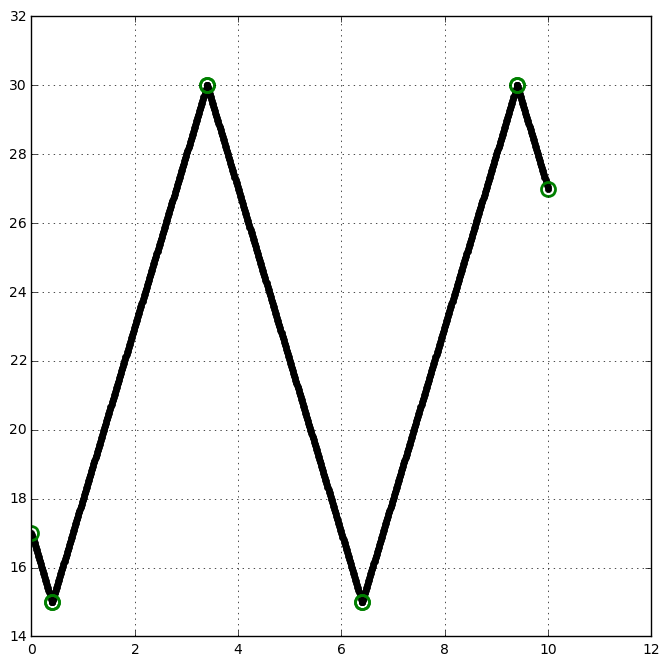

In [132]:
plt.figure(1,figsize=fs)
# continuous transitions
ax = plt.subplot(1,1,1); plt.grid('on')
ax.plot(tb,ob,'k.-',lw=lw,ms=ms)
ax.plot(tbd,obd, 'o',ms=ms,mew=mew,mec='g',mfc='None')

b. Simulate your literature example from HW1, explain the expected behavior, and provide a visualization that demonstrates the expected behavior.

In this question, I will simulate the 3 joints robot arm as I defined in hw2. The task is for the robot to servo the arm and grasp an object with mass m. The initial condition of the arm is  $\theta_1 = 45^{\circ}, \theta_2 = 80^{\circ}, \theta_3 = 0^{\circ}, \dot{\theta_1} = 0, \dot{\theta_2} = 0, \dot{\theta_3} = 0$, where $\theta_1$ is a rotational joints that rotates round z axis, $\theta_2$ and $\theta_3$ is a rotational joints that rotates around x axis. Another important assumption is that the third joint is locked up such that the gravitational force of any holding object only effect $\theta_2$.

In order to simplify the simulation, we assume the robot has super fast gripper closing speed such that whenever the robot endfactor matches the object pose, the robot will successfully grasp the object without stopping the arm movement. The simulation below simulate the robot arm move the gripper to grasp the object in position $(-0.274933138774, 0.274933138774, 0.956972141829)$ with constant input $u = [0,1,0]$, and the input does not change even when the robot is holding the object. Such that the discrete state change can be easily identified by the $\theta_2, \dot{\theta_2}$ valuses, since the object mass will change the acceleration and velocity of such joint.

System Description: 

Lets assume a robotic arm with a parallel jaws gripper has 3 degrees of freedom (3 rotational joints). In different object manipulation scenario, the system is described by difference $D$ and $F$. For example, when the robot is rotating a door knob, one or more joints can be contrained by the door knob. An other hand, if the gripper is holding an arbitrary object, joints will not be as contrained as the first example, but the weight of the object will still effect verticle oriented joints. Therefore, servoing this system is hybrid when the gripper different manipulation tasks.

We assume that $\theta_1$ represent the angle of base rotational joint which rotates along the z axis, $\theta_2$ represent a second joint that rotates along x axis, and $\theta_3$ rotate the gripper along x axis with respect to each of their own frame. link $l_1$ connects $\theta_1$ and $\theta_2$, $l_2$ connects $\theta_2$ and $\theta_3$, the gripper is mounted on the other side of $l_2$. Input $U = \{ (\tau_1, \tau_2, \tau_3)\}$ are the torques of joint 1, 2 and 3 for case 1 and 2.

The following simulation will describe the discrete states transistions in this system:

1. The gripper is not holding anything.
2. The gripper is holding an object with weight m.

For case 2 we define the grasp point (location) of the object to be $p_1 = (4, 8, 3)$ and the door knob grasp point at $p_2 = (2, 3, 4)$. And then we define an function $K(\theta_1, \theta_2, \theta_3)$ to calculate the forward kinamatic then return the gripper end factor pose in Cartisian cordination.

$\{ \forall d \in D | K(d) = p_1 \}$ has a force transistion from case 1 to 2.

In [133]:
import PyKDL as kdl

The robot class handles any kinematic transform of robotic arm.

In [245]:
# define forward kinematic
class robot():
    def __init__(self, chain):
        self.arm = chain
        self.endFactor = kdl.Frame()
        # create joint array
        self.nj = self.arm.getNrOfJoints()
        self.jointPositions = kdl.JntArray(self.nj)
        self.targetJointPos = kdl.JntArray(self.nj)

    def setJoints(self, radians):
        for i in range(self.nj):
            self.jointPositions[i] = radians[i]
        
    def findFK(self):
        # create solver
        fkSolver = kdl.ChainFkSolverPos_recursive(self.arm)
        # calculate fk
        fkSolver.JntToCart(self.jointPositions, self.endFactor) 

    def findIK(self, tarFrame):
        # create solver
        fkSolver = kdl.ChainFkSolverPos_recursive(self.arm)
        ikSolverVel = kdl.ChainIkSolverVel_pinv(self.arm)
        # Maximum 100 iterations, stop at accuracy 1e-6
        ikSolverPos = kdl.ChainIkSolverPos_NR(self.arm, fkSolver, ikSolverVel, 100, 1e-6)
        # calculate inverse kinematic
        ikSolverPos.CartToJnt(self.jointPositions, tarFrame, self.targetJointPos)
        
#print result.p
#print result.M

The following code tests all of the function of the robot class including forward and inverse kinematic. The result shows the robot class is working correctly.

In [247]:
chain = kdl.Chain()
s1 = kdl.Segment(kdl.Joint(kdl.Joint.RotZ), kdl.Frame(kdl.Vector(0.0,0.0,0.0)))
chain.addSegment(s1)
s2 = kdl.Segment(kdl.Joint(kdl.Joint.RotX))
chain.addSegment(s2)
s3 = kdl.Segment(kdl.Joint(kdl.Joint.RotX), kdl.Frame(kdl.Vector(0.0,0.0,0.5)))
chain.addSegment(s3)
s4 = kdl.Segment(kdl.Joint(kdl.Joint.RotX), kdl.Frame(kdl.Vector(0.0,0.0,0.5)))
chain.addSegment(s4)

arm = robot(chain)
arm.setJoints([0,0,0,math.pi/2])
arm.findFK()
print arm.endFactor

arm1 = robot(chain)
target = arm.endFactor
arm1.findIK(target)
print arm1.targetJointPos

[[           1,           0,           0;
            0, 6.12323e-17,          -1;
            0,           1, 6.12323e-17]
[           0,        -0.5,         0.5]]
0
-1.29203e-16
1.79361e-16
1.5708


The following code imprement the simulation software for this robotic arm system:

parameters $p = (m,p,objx,objy,objz)$ : $m$ - mass of the object, $g$ - gravitational acceleration, $objx,objy,objz$ - are the position of objects.


-0.274933138774 0.274933138774 0.956972141829


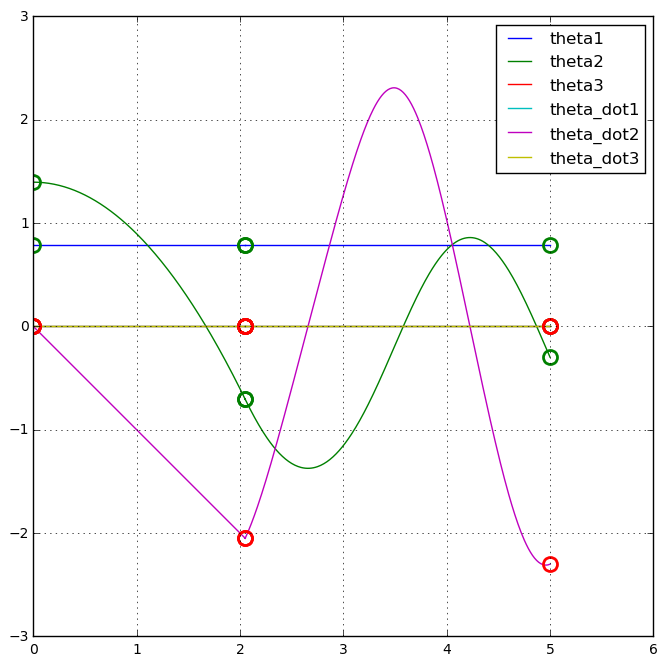

In [320]:
class simpleArm(Hybrid):
    def __init__(self):
        chain = kdl.Chain()
        s1 = kdl.Segment(kdl.Joint(kdl.Joint.RotZ), kdl.Frame(kdl.Vector(0.0,0.0,0.5)))
        chain.addSegment(s1)
        s2 = kdl.Segment(kdl.Joint(kdl.Joint.RotX), kdl.Frame(kdl.Vector(0.0,0.0,0.5)))
        chain.addSegment(s2)
        s3 = kdl.Segment(kdl.Joint(kdl.Joint.RotX), kdl.Frame(kdl.Vector(0.0,0.0,0.1)))
        chain.addSegment(s3)
        self.arm = robot(chain)
        Hybrid.__init__(self)
                         
    def F(self, (k,t), (j,x), u, **p):
        a,b,c,ad,bd,cd = x
        t1,t2,t3 = u
        if j == 0:
            o1, o2, o3 = t1, t2, t3
        else:
            o1, o2, o3 = t1, t2-m*g*math.sin(b), t3
        
        return np.array([ad, bd, cd, o1, o2, o3])
    
    def G(self, (k,t), (j,x), **p):
        '''this is a trival discrete state change, assuming the robot gripper
           will grasp and hold the object whenever the end factor matches the object position'''
        a,b,c,ad,bd,cd = x
        self.arm.setJoints([a,b,c])
        self.arm.findFK()
        pos = self.arm.endFactor.p
        g =  math.sqrt((pos[0]-objx)**2+(pos[1]-objy)**2+(pos[2]-objz)**2)
            
        return np.array([g])
    
    def R(self, (k,t),  (j,x), **p):
        tp = x
        k_ = k+1
        t_ = t
        x_ = x
        if j == 0:
            j_ = 1

        return (k_,t_),(j_,x_)
    
    def O(self, (k,t), (j,x), **p):
        a,b,c,ad,bd,cd = x
        self.arm.setJoints([a,b,c])
        self.arm.findFK()
        pos = self.arm.endFactor.p
        return [a,b,c,ad,bd,cd,pos[0],pos[1],pos[2]]
    
    def sim(self, (K,T), (j0,x0), u, dt, rx, **params):
        """
        guard testing is changed for the convenience of this particular case
        """
        dt0 = dt 

        k = 0
        t = [0.]
        j = deepcopy(j0)
        x = [deepcopy(x0)]

        trj = dict(k=k,t=t,j=j,x=x)
        trjs = []

        while ( trj['t'][-1] <= T # don't exceed max continuous time
                and trj['k'] < K # don't exceed max discrete transitions
                and not trj['j'] is None ): # don't allow discrete state is None
            k0 = trj['k']
            t0 = trj['t'][-1]
            j0 = trj['j']
            x0 = trj['x'][-1]
            if 0: # forward Euler
                dx = self.F((k0,t0), (j0,x0), u, **params)
            else: # 4th-order Runge-Kutta 
                f = lambda t,x : self.F((k0,t), (j0,x), u, **params)
                dx1 = f( t0, x0 ) * dt
                dx2 = f( t0+.5*dt, x0+.5*dx1 ) * dt
                dx3 = f( t0+.5*dt, x0+.5*dx2 ) * dt
                dx4 = f( t0+dt, x0+dx3 ) * dt
                dx = (1./6.)*( dx1 + 2*dx2 + 2*dx3 + dx4 ) / dt

            k = k0
            j = j0
            t = t0 + dt
            x = x0 + dt * dx
            g = self.G((k,t), (j,x), **params)

            # halve step size until trajectory doesn't violate guard more than rx
            i = 0
            imax = 50
            while np.any(g < -rx) and (i <= imax):
                dt  = dt/2.
                t  = t0 + dt
                x = x0 + dt * dx
                g = self.G((k,t), (j,x), **params)
                i += 1

            #if (i >= imax):
            #  raise RuntimeError,'(sim)  guard iterations exceeded -- you probably have a buggy guard'

            # append state to trj
            trj['t'].append(t)
            trj['x'].append(x)

            if 0 and 'debug' in params and params['debug']:
                print '  : (k,t)=(%s,%0.3f), (j,x)=(%s,%s), dt=%0.2e, g = %s, x = %s, dx = %s' % (k,t,j,x,dt,g,x,dx)

            # if in guard 
            #print "g before any is: ", g
            #print "any return: ", np.any(g < 0)
            if np.any(g < 0.000000005):
                #print"inside np.any"
                # spend time in guard
                if i >= imax:
                    t = t + rx
                else:
                    t = t + (rx + g.min())
                trj['t'].append(t)
                trj['x'].append(x)

                if 'debug' in params and params['debug']:
                  print 'rx: (k,t)=(%s,%0.3f), (j,x)=(%s,%s), dt=%0.2e, g = %s, x = %s' % (k,t,j,x,dt,g,x)

                # append trj to trjs
                trjs.append(trj)

                if 'Zeno' in params and params['Zeno'] and (len(trj['t']) <= 4):
                    print '(sim)  possible Zeno @ stepsize dt = %0.6f' % dt0
                    print 'rx: (k,t)=(%s,%0.3f), (j,x)=(%s,%s), dt=%0.2e, g = %s, x = %s' % (k,t,j,x,dt,g,x)
                    return trjs

                # apply reset to modify trj
                (k,t),(j,x) = self.R((k,t), (j,x), **params)
                trj = dict(k=k,t=[t],j=j,x=[x])

                # re-initialize step size
                dt = dt0

                if 'debug' in params and params['debug']:
                    g = self.G((k,t), (j,x), **params)
                    print 'rx: (k,t)=(%s,%0.3f), (j,x)=(%s,%s), dt=%0.2e, g = %s, x = %s' % (k,t,j,x,dt,g,x)

        trjs.append(trj)

        return trjs

if __name__ == "__main__":
    
    N = 10
    T = 5
    j = 0
    x = np.array([math.radians(45), math.radians(80), math.radians(0), 0, 0, 0])
    u = np.array([0,-1,0])
    m = 0.5
    g = 9.8
    objx,objy,objz = -0.274933138774, 0.274933138774, 0.956972141829
    debug = False
    Zeno = False
    p = dict(m=m,g=g,objx=objx,objy=objy,objz=objz,debug=debug,Zeno=Zeno)
    
    exp = simpleArm()
    
    h = 1e-2
    rx = 1e-6
    trjs = exp.sim((N,T), (j,x), u, h, rx, **p)
    
    (k,t),(j,o) = exp.obs(trjs, insert_nans=True, **p)
    (kd,td),(jd,od) = exp.obs(trjs, only_disc=True, **p)

    a,b,c,ad,bd,cd,endx,endy,endz = o.T
    da,db,dc,dad,dbd,dcd,dendx,dendy,dendz = od.T
    
    lw = 2
    mew = lw
    ms = 10
    lt = '-'
    fs = (8,8)
    
    print endx[205], endy[205], endz[205]
    
    plt.figure(1,figsize=fs)
    
    pic = plt.subplot(1,1,1); plt.grid('on')
    
    pic.plot(t,a, label='theta1')
    pic.plot(t,b, label='theta2')
    pic.plot(t,c, label='theta3')
    pic.plot(t,ad, label='theta_dot1')
    pic.plot(t,bd, label='theta_dot2')
    pic.plot(t,cd, label='theta_dot3')
    pic.plot(td, da, 'o',ms=ms,mew=mew,mec='g',mfc='None')
    pic.plot(td, db, 'o',ms=ms,mew=mew,mec='g',mfc='None')
    pic.plot(td, dc, 'o',ms=ms,mew=mew,mec='g',mfc='None')
    pic.plot(td, dad, 'o',ms=ms,mew=mew,mec='r',mfc='None')
    pic.plot(td, dbd, 'o',ms=ms,mew=mew,mec='r',mfc='None')
    pic.plot(td, dcd, 'o',ms=ms,mew=mew,mec='r',mfc='None')
    pic.legend()

The figure above shows the discrete state change of the system. Note that the circles in each trajectories indicate the beginning, discrete state change and end of the simulation. red circles are for joint velocity and green circles are for joint radians. The most interesting trajectory to look at is $\theta_2$ and $\dot{\theta_2}$, since the object mass will directly effect the two trajectories. $\dot{\theta_2}$ has a sharp change when $t \approx 2$ and $\theta_2$ changes trajectory as well compare to the figure below.

The following code simulate the arm is out of reach to the object such that there is no discrete state change in the simulation, in order to compare to the hybrid system above.

-0.274933138774 0.274933138774 0.956972141829


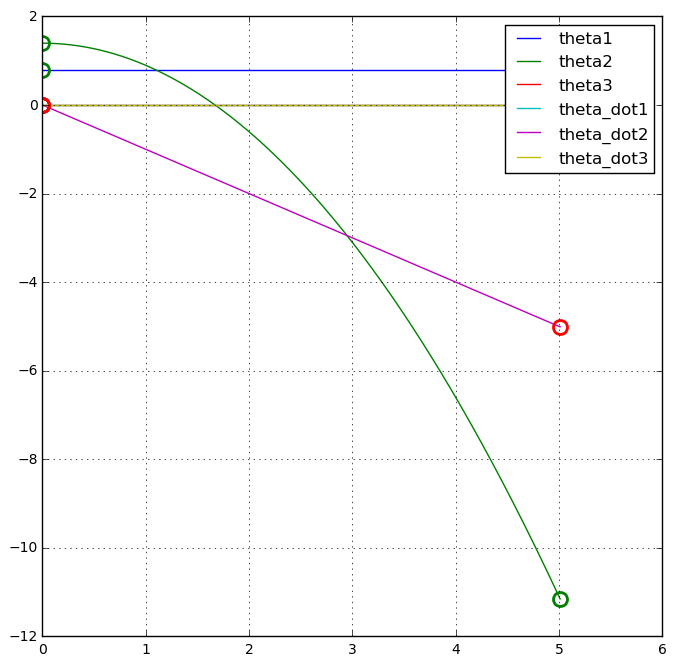

In [321]:
if __name__ == "__main__":
    
    N = 10
    T = 5
    j = 0
    x = np.array([math.radians(45), math.radians(80), math.radians(0), 0, 0, 0])
    u = np.array([0,-1,0])
    m = 0.5
    g = 9.8
    objx,objy,objz = 3, 3, 3
    debug = False
    Zeno = False
    p = dict(m=m,g=g,objx=objx,objy=objy,objz=objz,debug=debug,Zeno=Zeno)
    
    exp = simpleArm()
    
    h = 1e-2
    rx = 1e-6
    trjs = exp.sim((N,T), (j,x), u, h, rx, **p)
    
    (k,t),(j,o) = exp.obs(trjs, insert_nans=True, **p)
    (kd,td),(jd,od) = exp.obs(trjs, only_disc=True, **p)

    a,b,c,ad,bd,cd,endx,endy,endz = o.T
    da,db,dc,dad,dbd,dcd,dendx,dendy,dendz = od.T
    
    lw = 2
    mew = lw
    ms = 10
    lt = '-'
    fs = (8,8)
    
    print endx[205], endy[205], endz[205]
    
    plt.figure(1,figsize=fs)
    
    pic = plt.subplot(1,1,1); plt.grid('on')
    
    pic.plot(t,a, label='theta1')
    pic.plot(t,b, label='theta2')
    pic.plot(t,c, label='theta3')
    pic.plot(t,ad, label='theta_dot1')
    pic.plot(t,bd, label='theta_dot2')
    pic.plot(t,cd, label='theta_dot3')
    pic.plot(td, da, 'o',ms=ms,mew=mew,mec='g',mfc='None')
    pic.plot(td, db, 'o',ms=ms,mew=mew,mec='g',mfc='None')
    pic.plot(td, dc, 'o',ms=ms,mew=mew,mec='g',mfc='None')
    pic.plot(td, dad, 'o',ms=ms,mew=mew,mec='r',mfc='None')
    pic.plot(td, dbd, 'o',ms=ms,mew=mew,mec='r',mfc='None')
    pic.plot(td, dcd, 'o',ms=ms,mew=mew,mec='r',mfc='None')
    pic.legend()